In [1]:


%load_ext autoreload
%autoreload 2
%matplotlib inline



In [2]:

import re
import pandas as pd
import numpy as np

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set()



/data/miniconda3/envs/zoobot/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load Data and Filter to Original Sample, excluding strange end rows

In [43]:
gz2_catalog_loc = '/data/galaxy_zoo/gz2/catalogs/gz2_classifications_and_subjects.csv'  # replace this with your own catalog if desired
catalog = pd.read_csv(gz2_catalog_loc)

In [44]:
catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['smooth-or-featured_featured-fraction'] = catalog['t01_smooth_or_features_a02_features_or_disk_count']/catalog['smooth-or-featured_total-votes']

In [45]:
catalog = catalog[catalog['sample'] == 'original']

In [46]:
catalog = catalog[:190000]
catalog = catalog[catalog['smooth-or-featured_total-votes'] >= 30]
catalog['smooth-or-featured_total-votes'].min(), catalog['smooth-or-featured_total-votes'].max()

(30, 73)

In [68]:
catalog_cols = catalog.columns.values
features = [x for x in catalog_cols if x.startswith('t')][2:] # hacky but works
question_set = set([x[:re.search('_a[0-9]', x).span()[0]] for x in features if x])
question_set

AttributeError: 'NoneType' object has no attribute 'span'

In [67]:
qa_pairs = {}
for question in list(questions).sort():
    answer_cols = []
    for col in catalog_cols:
        if question in col and 'count' in col:
            answer_cols.append(col)
    qa_pairs[question] = answer_cols
print(qa_pairs)

{'t07_rounded': ['t07_rounded_a16_completely_round_count', 't07_rounded_a17_in_between_count', 't07_rounded_a18_cigar_shaped_count'], 't01_smooth_or_features': ['t01_smooth_or_features_a01_smooth_count', 't01_smooth_or_features_a02_features_or_disk_count', 't01_smooth_or_features_a03_star_or_artifact_count'], 't10_arms_winding': ['t10_arms_winding_a28_tight_count', 't10_arms_winding_a29_medium_count', 't10_arms_winding_a30_loose_count'], 't06_odd': ['t06_odd_a14_yes_count', 't06_odd_a15_no_count'], 't09_bulge_shape': ['t09_bulge_shape_a25_rounded_count', 't09_bulge_shape_a26_boxy_count', 't09_bulge_shape_a27_no_bulge_count'], 't05_bulge_prominence': ['t05_bulge_prominence_a10_no_bulge_count', 't05_bulge_prominence_a11_just_noticeable_count', 't05_bulge_prominence_a12_obvious_count', 't05_bulge_prominence_a13_dominant_count'], 't02_edgeon': ['t02_edgeon_a04_yes_count', 't02_edgeon_a05_no_count'], 't11_arms_number': ['t11_arms_number_a31_1_count', 't11_arms_number_a32_2_count', 't11_arms

TODO sum over these columns for total answers to each column, save in named column, and visualise

In [59]:
for question, answers in qa_pairs.items():
    catalog[question + '_total'] = catalog[answers].sum(axis=1)

In [85]:
# def argsort_seq(seq):
#     return [i for (v, i) in sorted((v, i) for (i, v) in enumerate(seq))]

In [94]:
catalog['t08_odd_feature_total'].mean(), catalog['t01_smooth_or_features_total'].mean(), catalog['t05_bulge_prominence_total'].mean()

(7.235602456811366, 43.139093238441745, 10.16877526994561)

In [111]:
renaming = {
    't01_smooth_or_features': 'Smooth or Featured?',
    't06_odd': 'Anything Odd?',
    't07_rounded': 'How Rounded?',
    't02_edgeon': 'Edge On Disk?',
    't03_bar': 'Bar?',
    't04_spiral': 'Spiral Arms?',
    't05_bulge_prominence': 'Bulge Size?',
    't08_odd_feature': "What's Odd?",
    't10_arms_winding': 'Spiral Arm Winding?',
    't09_bulge_shape': 'Bulge Shape?',
    't11_arms_number': 'Spiral Arm Count?',
}

    Mean Responses             Question
1        43.139093  Smooth or Featured?
3        41.419070        Anything Odd?
0        28.951572         How Rounded?
6        12.457067        Edge On Disk?
9        10.172062                 Bar?
10       10.170730         Spiral Arms?
5        10.168775          Bulge Size?
8         7.235602          What's Odd?
2         6.003420  Spiral Arm Winding?
7         6.002541    Spiral Arm Count?
4         2.283822         Bulge Shape?


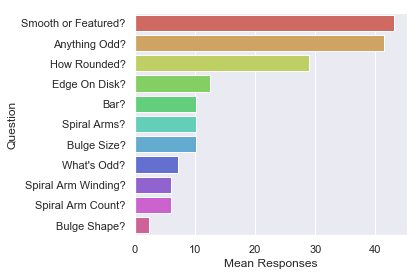

In [132]:
all_questions = qa_pairs.keys()
mean_votes = [catalog[question + '_total'].mean() for question in all_questions]
data = [{'Question': renaming[question], 'Mean Responses': mean_vote} for question, mean_vote in zip(all_questions, mean_votes)]
df = pd.DataFrame(data).sort_values('Mean Responses', ascending=False)
print(df)
fig, ax = plt.subplots()
sns.barplot(data=df, y='Question', x='Mean Responses', palette=sns.hls_palette(len(df), l=.6, s=.7), ax=ax)
fig.tight_layout()
fig.savefig('/data/repos/latex/active_learning/figures/mean_votes_per_question_latest.png')

{'t07_rounded': 4, 't01_smooth_or_features': 7, 't10_arms_winding': 2, 't06_odd': 8, 't09_bulge_shape': 5, 't05_bulge_prominence': 10, 't02_edgeon': 9, 't11_arms_number': 6, 't08_odd_feature': 0, 't03_bar': 3, 't04_spiral': 1}
4 t07_rounded 28.951572263388076
7 t01_smooth_or_features 43.139093238441745
2 t10_arms_winding 6.003419932560209
8 t06_odd 41.4190695865717
5 t09_bulge_shape 2.2838224405107526
10 t05_bulge_prominence 10.16877526994561
9 t02_edgeon 12.457067061574767
6 t11_arms_number 6.0025409779302485
0 t08_odd_feature 7.235602456811366
3 t03_bar 10.172062027561886
1 t04_spiral 10.170730278122553


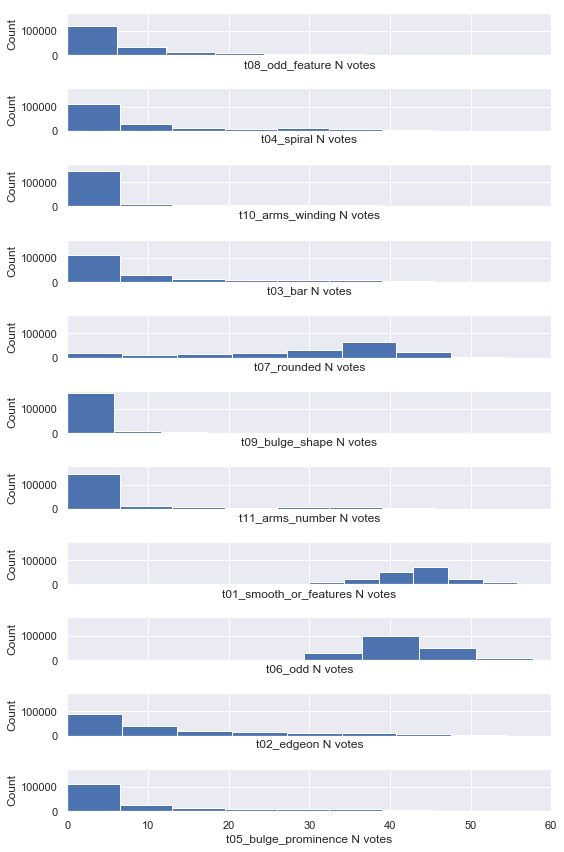

In [95]:
fig, axes = plt.subplots(nrows=len(qa_pairs), figsize=(8, 12), sharex=True, sharey=True)
question_n = 0

sort_indices = np.argsort()
index_lookup = dict(zip(all_questions, sort_indices))
print(index_lookup)
for question, answers in qa_pairs.items():
    question_n = index_lookup[question]
    print(question_n, question, catalog[question + '_total'].mean())
    axes[question_n].hist(catalog[question + '_total'])
    axes[question_n].set_xlabel(question + ' N votes')
    axes[question_n].set_ylabel('Count')
    axes[question_n].set_xlim([0, 60])
fig.tight_layout()

In [64]:
len(qa_pairs)

11